In [39]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import time
import os
import sys
import json

import scipy as sp
from scipy import signal

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from keras.callbacks import EarlyStopping
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import os, warnings, random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers, Sequential, Model
from tensorflow.keras.callbacks import LearningRateScheduler

In [40]:
SEED = 13
tf.random.set_seed(SEED)

In [41]:
def encode_gait_percentage(df, name):
  percent = df[name].values.tolist()
  X = np.zeros((len(df[name]),1))
  Y = np.zeros((len(df[name]),1))
  for i in range (len(percent)):
    phi = percent[i] * 2 * math.pi / 100
    X[i] = math.cos(phi)
    Y[i] = math.sin(phi)
  df['X'] = X
  df['Y'] = Y

In [42]:
def convert_data(d_x, d_y, look_back = 1, fore_cast = 1):
    dataX = []
    dataY = []

    for i in range(look_back, len(d_x) - fore_cast):
        dataX.append(d_x[i - look_back: i])
        dataY.append(d_y[i + fore_cast,:])

    return np.array(dataX), np.array(dataY)

In [43]:
#from google.colab import drive

#rive.mount('/content/drive')
#path =path = '/content/drive/MyDrive/nmchr_lab/Subjects/inclined/new/right_based/'


In [44]:
working_dir = os.getcwd()#os.path.dirname(os.getcwd())
sys_platform = sys.platform
excel_path_dict = {'linux' : "/csvs/", 'win32' : "\Data\Incline\\right_based\\"}
excel_path_name = excel_path_dict[sys_platform]

directory_path = working_dir 
print(directory_path)
excel_path = directory_path + excel_path_name


c:\Users\Admin\Desktop\Neurorobotic Lab\Data_Code\Model\Gait_Phase_Prediction


In [45]:


sub1_file = ['TH\TH_I_0.xlsx', 'TH\TH_I_2.xlsx', 'TH\TH_I_3.xlsx', 'TH\TH_I_4.xlsx', 'TH\TH_I_5.xlsx' ]
sub2_file = ['JL\JL_I_0.xlsx', 'JL\JL_I_2.xlsx', 'JL\JL_I_3.xlsx', 'JL\JL_I_4.xlsx', 'JL\JL_I_5.xlsx' ]
sub3_file = ['SD\SD_1_I.xlsx', 'SD\SD_2_I.xlsx', 'SD\SD_3_I.xlsx', 'SD\SD_4_I.xlsx', 'SD\SD_5_I.xlsx']
sub4_file = ['PK\PK_0_I.xlsx', 'PK\PK_5_I.xlsx', 'PK\PK_2_I.xlsx', 'PK\PK_3_I.xlsx']
sub5_file = ['SKS\SKS_0_I.xlsx', 'SKS\SKS_4_I.xlsx', 'SKS\SKS_2_I.xlsx', 'SKS\SKS_3_I.xlsx', 'SKS\SKS_5_I.xlsx']
sub6_file = ['SOE\SOE_I_0.xlsx', 'SOE\SOE_I_2.xlsx', 'SOE\SOE_I_3.xlsx', 'SOE\SOE_I_4.xlsx', 'SOE\SOE_I_5.xlsx']
sub7_file = ['VP\VP_I_0.xlsx', 'VP\VP_I_2.xlsx', 'VP\VP_I_3.xlsx', 'VP\VP_I_5.xlsx']

file_name = sub1_file

file_list=[]

for i in range (len(file_name)):
    file_list.append(pd.read_excel(excel_path + file_name[i], sheet_name='Sheet1'))

import random
random.shuffle(file_list)

all_data = pd.concat(file_list, axis=0, ignore_index=True)


In [46]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297989 entries, 0 to 297988
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   n_lcop        297989 non-null  float64
 1   n_rcop        297989 non-null  float64
 2   l_ph_ank      297989 non-null  float64
 3   l_ph_hip      297989 non-null  float64
 4   l_ph_fo       297989 non-null  float64
 5   r_ph_ank      297989 non-null  float64
 6   r_ph_hip      297989 non-null  float64
 7   r_ph_fo       297989 non-null  float64
 8   n_lgrf        297989 non-null  float64
 9   n_r_grf       297989 non-null  float64
 10  st_sw_phase   297989 non-null  int64  
 11  perc_new      297989 non-null  float64
 12  strike_frame  297989 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 29.6 MB


In [47]:
cycle = 0
cycle_list = []

start = 0

for i in range(len(all_data) - 1):
    if (all_data['perc_new'][i+1] == 0):
        cycle += 1
        cycle_list.append(all_data.iloc[start:i])
        start = i+1

random.shuffle(cycle_list)
source_table = pd.concat(cycle_list, axis=0, ignore_index=True)

source_table


,n_lcop,n_rcop,l_ph_ank,l_ph_hip,l_ph_fo,r_ph_ank,r_ph_hip,r_ph_fo,n_lgrf,n_r_grf,st_sw_phase,perc_new,strike_frame
0,0.000364,0.003788,0.0,335.708587,0.614113,0.000000,101.075047,298.016521,0.097159,2.276750,0,0.000000,1
1,0.000430,0.003753,0.0,334.412900,0.689073,0.000000,99.826256,306.219088,0.159518,2.227656,0,0.526316,2
2,0.000501,0.003709,0.0,333.205903,0.766017,0.000000,98.731376,321.457705,0.237671,2.165679,0,1.052632,3
3,0.000575,0.003656,0.0,332.074913,0.844150,0.000000,97.756857,349.705864,0.331411,2.090583,0,1.578947,4
4,0.000652,0.003593,0.0,331.006217,0.922499,0.000000,96.876378,25.073364,0.439191,2.002423,0,2.105263,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
296368,0.000060,0.003219,0.0,347.690075,359.392514,359.999655,117.825531,295.570418,0.000000,2.033766,0,97.333333,220
296369,0.000087,0.003258,0.0,346.240029,359.483626,359.999674,113.701475,295.924535,0.000000,2.040064,0,97.777778,221
296370,0.000118,0.003294,0.0,344.815322,359.595981,359.999697,110.429608,296.404137,0.000000,2.043643,0,98.222222,222
296371,0.000154,0.003328,0.0,343.422210,359.729012,359.999724,107.779162,297.051408,0.000000,2.043835,0,98.666667,223


In [48]:
drop_list = ["n_lgrf","n_r_grf","l_ph_ank","r_ph_ank"]

In [49]:
source_table = source_table.drop(drop_list, axis = 1)
source_table

,n_lcop,n_rcop,l_ph_hip,l_ph_fo,r_ph_hip,r_ph_fo,st_sw_phase,perc_new,strike_frame
0,0.000364,0.003788,335.708587,0.614113,101.075047,298.016521,0,0.000000,1
1,0.000430,0.003753,334.412900,0.689073,99.826256,306.219088,0,0.526316,2
2,0.000501,0.003709,333.205903,0.766017,98.731376,321.457705,0,1.052632,3
3,0.000575,0.003656,332.074913,0.844150,97.756857,349.705864,0,1.578947,4
4,0.000652,0.003593,331.006217,0.922499,96.876378,25.073364,0,2.105263,5
...,...,...,...,...,...,...,...,...,...
296368,0.000060,0.003219,347.690075,359.392514,117.825531,295.570418,0,97.333333,220
296369,0.000087,0.003258,346.240029,359.483626,113.701475,295.924535,0,97.777778,221
296370,0.000118,0.003294,344.815322,359.595981,110.429608,296.404137,0,98.222222,222
296371,0.000154,0.003328,343.422210,359.729012,107.779162,297.051408,0,98.666667,223


In [50]:
x = source_table
x = x.drop(['perc_new'], axis=1)
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled)

encode_gait_percentage(source_table, 'perc_new')
y = source_table[["X","Y"]]
y

data_x = x_scaled


In [51]:
data_y = y.values.reshape(-1,2)

In [52]:
type(data_y)

numpy.ndarray

In [53]:

#data_x,data_y= shuffle_multiple_datasets_based_on_gait_cycle( file_name, excel_path)

X_train, X_test,y_train, y_test = train_test_split(data_x, data_y ,
                        test_size=0.25,
                        shuffle=False)
look_back = 10
fore_cast = 1

train_x, train_y = convert_data(X_train, y_train, look_back, fore_cast)
validation_x, validation_y = convert_data(X_test, y_test, look_back, fore_cast)


In [54]:
print(train_x.shape)
print(train_y.shape)
print(validation_x.shape)
print(validation_y.shape)


(222268, 10, 8)
(222268, 2)
(74083, 10, 8)
(74083, 2)


In [55]:
train_x.shape

(222268, 10, 8)

In [56]:
n1=validation_x.shape[0]
val_x=validation_x[1:int(n1/10),:]
val_y=validation_y[1:int(n1/10),:]
print(val_x.shape)
print(val_y.shape)

(7407, 10, 8)
(7407, 2)


In [57]:
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [58]:

lr = 0.001
epochs = 30
batch = 128

x=Input(shape=(10, train_x.shape[2]))
n_features=train_x.shape[2]
# RNN_layer = SimpleRNN(hidden_units, return_sequences=True, activation=activation)(x)
LSTM_layer1 = LSTM(64, return_sequences=True)(x)
LSTM_layer2 = LSTM(32, return_sequences=True)(LSTM_layer1)
attn_layer1 = attention()(LSTM_layer2)
rep_layer = L.RepeatVector((10))(attn_layer1)
# attn_layer2 = attention()(rep_layer)
LSTM_layer3 = LSTM(32, return_sequences=True)(rep_layer)
LSTM_layer4 = LSTM(64, return_sequences=True)(LSTM_layer3)
lin_layer = L.TimeDistributed(L.Dense(n_features))(LSTM_layer4)
# tmp_layer = Flatten()(rep_layer)
# lin_layer = L.Dense(2)(tmp_layer)
model=Model(x,lin_layer)
model.summary()
adam = optimizers.Adam(lr)
model.compile(loss='mse', optimizer=adam)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 8)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 10, 64)            18688     
                                                                 
 lstm_5 (LSTM)               (None, 10, 32)            12416     
                                                                 
 attention_1 (attention)     (None, 32)                42        
                                                                 
 repeat_vector_1 (RepeatVect  (None, 10, 32)           0         
 or)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 10, 32)            8320      
                                                           

In [59]:
model_history = model.fit( train_x, train_x, epochs=epochs, batch_size=batch,  verbose=1)

Epoch 1/30
1737/1737 [==============================] - 46s 24ms/step - loss: 0.0118
Epoch 2/30
1737/1737 [==============================] - 42s 24ms/step - loss: 0.0029
Epoch 3/30
1737/1737 [==============================] - 40s 23ms/step - loss: 0.0019
Epoch 4/30
1737/1737 [==============================] - 40s 23ms/step - loss: 0.0013
Epoch 5/30
1737/1737 [==============================] - 40s 23ms/step - loss: 9.6620e-04
Epoch 6/30
1737/1737 [==============================] - 41s 23ms/step - loss: 7.5087e-04
Epoch 7/30
1737/1737 [==============================] - 41s 24ms/step - loss: 6.2994e-04
Epoch 8/30
1737/1737 [==============================] - 42s 24ms/step - loss: 5.4458e-04
Epoch 9/30
1737/1737 [==============================] - 42s 24ms/step - loss: 4.5842e-04
Epoch 10/30
1737/1737 [==============================] - 42s 24ms/step - loss: 4.1254e-04
Epoch 11/30
1737/1737 [==============================] - 43s 25ms/step - loss: 3.5845e-04
Epoch 12/30
1737/1737 [============

In [60]:
encoder = Model(inputs=model.inputs, outputs=model.layers[3].output)
train_encoded = encoder.predict(train_x)
validation_encoded = encoder.predict(validation_x)
print('Encoded time-series shape', train_encoded.shape)
print('Encoded time-series sample', train_encoded[0])

2316/2316 [==============================] - 8s 3ms/step
Encoded time-series shape (222268, 32)
Encoded time-series sample [-0.13815333 -0.15973684 -0.25814897 -0.26490897 -0.08706301  0.32453248
  0.12504044 -0.51145494 -0.03713031 -0.55144805 -0.10739916 -0.4148514
 -0.19859211 -0.6727979   0.20661433 -0.32740784 -0.42530048  0.31008092
  0.32668    -0.49918875  0.20034459 -0.41046157 -0.8186548   0.5559026
  0.8586995   0.54466575  0.6975552  -0.34927294 -0.6458723  -0.21135695
  0.10223921 -0.07771058]


In [61]:
#model.save(path+"autoen_new_model")

In [62]:
def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.005
	epochs_drop = 10
	lrate=initial_lrate - 0.00001
	# lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate


In [63]:
mlp_model = Sequential()
mlp_model.add(L.Dense(32, kernel_initializer='glorot_normal', activation='relu', input_dim=(train_encoded.shape[1])))
# mlp_model.add(L.Dense(32, kernel_initializer='glorot_normal', activation='relu', input_dim=(train_encoded.shape[1])))

mlp_model.add(L.Dense(8, kernel_initializer='glorot_normal', activation='relu'))
mlp_model.add(L.Dense(2))
mlp_model.summary()

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
adam = optimizers.Adam(lr_schedule)

mlp_model.compile(loss='mse', optimizer=adam)
lrate = LearningRateScheduler(step_decay)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 8)                 264       
                                                                 
 dense_7 (Dense)             (None, 2)                 18        
                                                                 
Total params: 1,338
Trainable params: 1,338
Non-trainable params: 0
_________________________________________________________________


In [64]:
epochs = 50
# lrate = LearningRateScheduler(step_decay)
monitor = EarlyStopping(monitor='loss', min_delta=1e-5, patience=3, verbose=1, mode='auto')
# train_encoded_reshaped=np.reshape(train_encoded,(train_encoded.shape[0], train_encoded.shape[1]*train_encoded.shape[2]))

# train_encoded_reshaped=np.reshape(train_encoded,(train_encoded.shape[0], train_encoded.shape[1]))
train_encoded_reshaped = train_encoded
callback_list = [monitor]
mlp_history = mlp_model.fit(train_encoded_reshaped , train_y, callbacks=callback_list, epochs=epochs, batch_size=batch,  verbose=2)

Epoch 1/50
1737/1737 - 2s - loss: 0.0244 - 2s/epoch - 1ms/step
Epoch 2/50
1737/1737 - 2s - loss: 0.0045 - 2s/epoch - 975us/step
Epoch 3/50
1737/1737 - 2s - loss: 0.0040 - 2s/epoch - 957us/step
Epoch 4/50
1737/1737 - 2s - loss: 0.0038 - 2s/epoch - 956us/step
Epoch 5/50
1737/1737 - 2s - loss: 0.0036 - 2s/epoch - 936us/step
Epoch 6/50
1737/1737 - 2s - loss: 0.0035 - 2s/epoch - 925us/step
Epoch 7/50
1737/1737 - 2s - loss: 0.0034 - 2s/epoch - 919us/step
Epoch 8/50
1737/1737 - 2s - loss: 0.0034 - 2s/epoch - 938us/step
Epoch 9/50
1737/1737 - 2s - loss: 0.0033 - 2s/epoch - 919us/step
Epoch 10/50
1737/1737 - 2s - loss: 0.0032 - 2s/epoch - 931us/step
Epoch 11/50
1737/1737 - 2s - loss: 0.0032 - 2s/epoch - 950us/step
Epoch 12/50
1737/1737 - 2s - loss: 0.0032 - 2s/epoch - 920us/step
Epoch 13/50
1737/1737 - 2s - loss: 0.0031 - 2s/epoch - 961us/step
Epoch 14/50
1737/1737 - 2s - loss: 0.0031 - 2s/epoch - 909us/step
Epoch 15/50
1737/1737 - 2s - loss: 0.0031 - 2s/epoch - 923us/step
Epoch 16/50
1737/1737

In [65]:
val_encoded_reshaped = validation_encoded
trainPredict = mlp_model.predict(train_encoded_reshaped)
testPredict = mlp_model.predict(val_encoded_reshaped)

2316/2316 [==============================] - 2s 949us/step


In [66]:
testPredict.shape

(74083, 2)

In [67]:
from sklearn.metrics import mean_squared_error

trainScore = np.sqrt(mean_squared_error(train_y, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(validation_y, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.05 RMSE
Test Score: 0.05 RMSE


In [68]:
v = X_test[11:]
v.shape

(74083, 8)

In [69]:

x_test = scaler.inverse_transform(v)

pred = np.zeros((len(testPredict),1))

for iter in range(len(testPredict)):
  x = testPredict[iter][0]
  y = testPredict[iter][1]
  pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))


  if ((pred[iter] >= 80) & (x_test[iter][-1] <= 20)) :
    pred[iter] = pred[iter] - 100
    
    if abs(pred[iter]) >= 5:
        pred[iter] = 0


  if ((pred[iter] <= 20) & (x_test[iter][-1] >= 150)):
     pred[iter] = 100 - pred[iter]
     if abs(pred[iter]) >= 5:
         pred[iter] = 100




  #if (pred[iter] > 100):
  #  pred[iter] = pred[iter] - 100

pred1=pd.DataFrame(pred).sort_index().reset_index()

In [70]:
actual = np.zeros((len(validation_y),1))

for iter in range(len(validation_y)):
  x =validation_y[iter][0]
  y =validation_y[iter][1]
  actual[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

In [71]:
correct = 0
for i in range(5):
  correct = 0
  for iter in range(len(actual)):
    #if (abs(actual[iter] - pred[iter]) <= (i+1)) or (actual[iter]>98) or(actual[iter]<3):
      #correct+=1
      if (abs(actual[iter] - pred[iter]) <= (i+1)):
        correct+=1

  print(correct)
  print(len(actual))

  print("Precision ", i+1, ": ", correct * 100/len(actual))

49427
74083
Precision  1 :  66.71841043154299
68269
74083
Precision  2 :  92.15204567849574
72492
74083
Precision  3 :  97.85240878474144
73729
74083
Precision  4 :  99.52215758001161
73957
74083
Precision  5 :  99.8299204945804


In [72]:
perc_rmse = np.sqrt(mean_squared_error(actual, pred))
print("Predicting Percentage RMSE: ", perc_rmse)



Predicting Percentage RMSE:  1.1633869074632894


In [73]:
rmse = 0
length = len(actual)
for i in range(len(actual)):

    rmse = rmse + pow(pred[i] - actual[i], 2)
rmse = rmse / length
rmse = math.sqrt(rmse)
print(length)
print(len(actual))
print(rmse)

74083
74083
1.1633869074632954


49914
74083


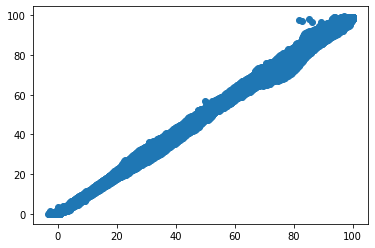

In [74]:
correct = 0

plt.figure()
plt.scatter(pred, actual)
for iter in range(len(actual)):
  if actual[iter]<2 or actual[iter]>98:
    correct+=1
    continue
  if (abs(actual[iter] - pred[iter]) <= 1):
    correct+=1


print(correct)
print(len(actual))

Text(0.5, 1.0, 'Actual vs Prediction')

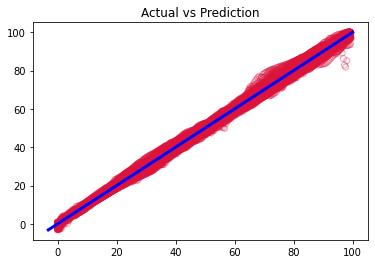

In [75]:
plt.scatter(actual, pred, facecolors='none', edgecolors='crimson',alpha=0.4)
p1 = max(max(pred), max(actual))
p2 = min(min(pred), min(actual))

ci = 0.1 * np.std([p1,p2]) / np.mean([p1,p2])

plt.plot([p1, p2], [p1, p2], 'b-', linewidth =3)
plt.title('Actual vs Prediction')

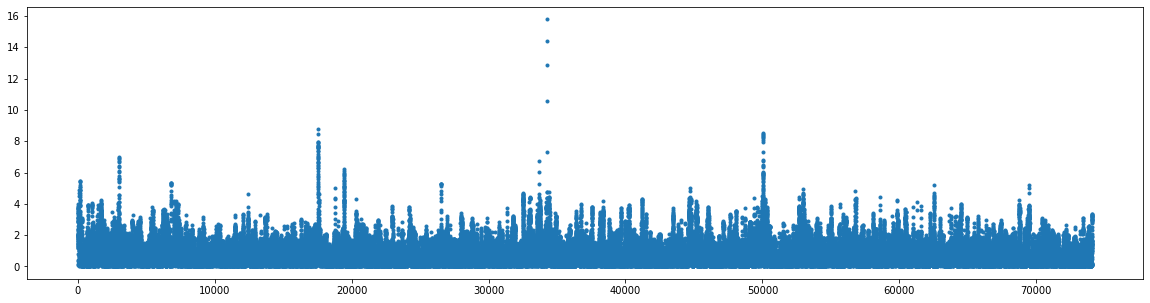

In [76]:
predfig=plt.figure(figsize=(20,5))
dif = abs(actual-pred)

plt.plot(dif,'.')